# Saltatory evolution (Figure 6)
Rebound model with adaptive leaky integrated-and-fire neuron.

In [1]:
import numpy as np
import string
import matplotlib.pyplot as plt

from resonance import plotting
from resonance.neuralnodes import utils
from resonance.rebound_adapt.lifac import lifac_all

from resonance.rebound_adapt.model import run_model
from resonance.rebound_adapt.params import Params

alphabet = list(string.ascii_uppercase)
plt.style.use('ncb.mplstyle')

def sigmoidal(x, slope=1, midpoint=0, gain=1, offset=0):
    return offset + gain / (1 + np.exp( -slope * (x - midpoint)))

def relu(x, thres):
    return np.maximum(x - thres, 0)


In [ ]:
taums = [8.6, 12]
alphas = [10, 10]
# thress = [None, 140, 95, None]

stim_step = 0.1
fs = 4_000.0
max_len = 20

params = Params.from_yaml("params/rebound_adapt_20230304_143838_66_params.yaml")
params_file = np.array(params.to_list())

input_stim, s, paui, duri = utils.makePPFstim(ppauMax=max_len, pdurMax=max_len, cdur=1000, cpau=0, Fs=fs, step=stim_step)
new_points = np.array([s["ppau"], s["pdur"]]).T / fs * 1000
paui = paui / fs * 1000
duri = duri / fs * 1000

input_stim = np.array(input_stim)
time = np.arange(0, np.shape(input_stim)[0], 1)

outs = run_model(input_stim, params_file, fs)

ppf_rb = np.mean(outs[-1], axis=0)
ppf_rb = ppf_rb.reshape((len(duri), len(paui)))
paui_rb = paui
duri_rb = duri

ppfs = []
for taum, alpha in zip(taums, alphas):
    params_file[-5:] = [taum, 0.1, 5, alpha, 0.5]  # all
    ppf, _, _ ,_= lifac_all(time, outs, params_file)
    ppfs.append(ppf)


0.26160417197577385
40
66


/var/folders/lz/h0pd23610q36ss5zm1x9kfn0gy02sm/T/ipykernel_8367/3700686371.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


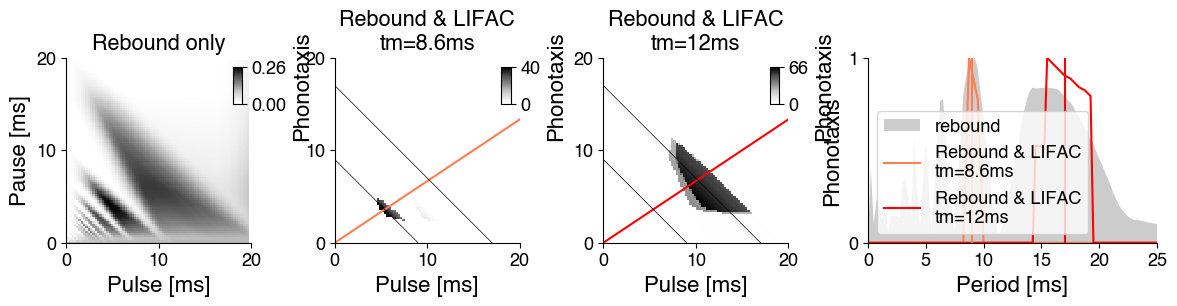

In [ ]:
thress = [72, 0]
labels = ['Rebound & LIFAC\ntm=8.6ms', 'Rebound & LIFAC\ntm=12ms']

col_per = ['coral', 'red']
col_dc = ['violet', 'darkorchid', 'indigo']

pers = [9, 17]

fig, axs0 = plt.subplots(1, 4, figsize=(12, 3), width_ratios=[1,1,1,1.5])
axs = axs0
plotting.ppf(duri_rb, paui_rb, ppf_rb, axs[0])
print(np.max(ppf_rb))

axs[0].set_title('Rebound only')
axs[0].set_xticks([0, 10, 20])
axs[0].set_yticks([0, 10, 20])

# PPFs
for ax, taum, alpha, thres, label, ppf, col in zip(axs[1:], taums, alphas, thress, labels, ppfs, col_per):
    if thres is not None:
        ppf = relu(ppf, thres)
    ppf = ppf.reshape((len(duri_rb), len(paui_rb)))
    print(np.max(ppf))

    plotting.ppf(duri_rb, paui_rb, ppf, ax)
    ax.set_title(label)
    ax.set_ylabel(None)
    ax.plot(duri_rb[[0,-1]] * 1.5, paui_rb[[0,-1]], color=col)
    for per, col in zip(pers, col_per):
        ax.plot([0, per], [per, 0 ], c='k', linewidth=0.5)
    ax.set_xticks([0, 10, 20])
    ax.set_yticks([0, 10, 20])


# period tuning
stim_step = 0.04
input_stim, s, paui, duri = utils.makePPFstim(ppau=np.arange(0.1,20,stim_step)/1.5, pdur=np.arange(0.1,20,stim_step), cdur=1000, cpau=0, Fs=fs, step=stim_step)
paui = paui / fs * 1000
duri = duri / fs * 1000
pperi = paui + duri

input_stim = np.array(input_stim)
time = np.arange(0, np.shape(input_stim)[0], 1)
outs = run_model(input_stim, params_file, fs)
tune_rb = np.mean(outs[-1], axis=0)

# axs = axs0[0, :]
# axs[-1].plot(pperi, tune_rb / np.max(tune_rb), label='rb', c='k')
axs[-1].fill_between(pperi, tune_rb / np.max(tune_rb), facecolor='k', alpha=0.2, edgecolor=None, label='rebound')

tune_rb = relu(tune_rb, 0.22)
# axs[-1].plot(pperi, tune_rb / np.max(tune_rb), label='rb')

for ax, taum, alpha, thres, label, col in zip(axs[1:], taums, alphas, thress, labels, col_per):
    params_file[-5:] = [taum, 0.1, 5, alpha, 0.5]  # all
    ppf, _, _ ,_ = lifac_all(time, outs, params_file)

    if thres is not None:
        ppf = relu(ppf, thres)
    axs[-1].plot(pperi, ppf / np.max(ppf), label=label, color=col)
    # ax.plot(pperi, ppf / np.max(ppf), '--')
    # ax.fill_between(pperi, ppf / np.max(ppf), color='k', alpha=0.2)
axs[-1].vlines(pers, 0, 1, color=col_per)
axs[-1].set_xlim(0, 25)
axs[-1].set_xticks(np.arange(0, 26, 5))
axs[-1].set_yticks([0, 1])
axs[-1].set_ylabel('Phonotaxis')
axs[-1].set_xlabel('Period [ms]')
axs[-1].legend()
plt.tight_layout()
plt.savefig('fig/fig_saltatory.pdf')
plt.show()
